In [9]:
import numpy as np
import matplotlib.pylab as plt
import glob
import MDAnalysis
import sys
import matplotlib.lines as mlines
mev_to_kj=96.485307/1000.

SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title,'#ffff33'
colors=['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999']*3
markers=["o"]*8+["s"]*8+['^']*8

In [10]:
def extract_form_log(fn):
    lines=open(fn,'r').readlines()
    start=np.where([('Step' in l) for l in lines])[-1][0]
    data={keyi.lower(): []  for keyi in lines[start].split()}
    for l in lines[start+1:]:
        ls=l.split()
        try:
            if ls[0].isdigit():
                for i, key in enumerate(data.keys()):
                    data[key].append(float(ls[i]))

            else:
                continue
        except:
            continue
    for key in data.keys():
        data[key]=np.array(data[key])
    return data

In [11]:
def ReadBox(fn):
    with open(fn,'r') as fp:
        lines=fp.readlines()
    out=dict()
    for l in lines:
        l2=l.replace('[','').replace(']','')
        ls=l2.split()
        key='/'.join(ls[0].split('/')[1:])
        if key not in out.keys():
            out[key]=dict()
        prop=ls[1]
        if 'Vol' in prop:
            out[key][ls[1]]=float(ls[-2])
            out[key]['Dens']= 18.01528*(float(ls[-1])*1.660539040E-27)/(float(ls[-2])*1.0E-30)/1000.
        if 'Dims' in prop:
            out[key][ls[1]]=[float(fi)  for fi in ls[2:-1]]
        if 'Energy' in prop:
            out[key][ls[1]]=float(ls[-1])*1000/23.06054
            
    return out

In [12]:
def extract_deepmd(folders,replace=''):
    deepmd=dict()

    for folder in folders:
        try:
            log=extract_form_log(folder+'/log.lammps')
        except:
            continue
        nwaters=MDAnalysis.Universe(folder+'/water.data').atoms.n_atoms//3
        start=len(log['step'])//10

        energy=log['poteng'][start:].mean()/nwaters*1000
        volume=log['volume'][start:].mean()/nwaters
        density=nwaters/log['volume'][start:].mean()*(15.9994+2*1.007840)*1.660539066E-27/1E-27
        dims=[log['cella'][start:].mean(),log['cellb'][start:].mean(),log['cellc'][start:].mean(),log['cellalpha'][start:].mean(),log['cellbeta'][start:].mean(),log['cellgamma'][start:].mean()]
        key=folder.replace(replace,'')
        deepmd[key]=dict()
        deepmd[key]['Dens']=density
        deepmd[key]['Energy']=energy
    return deepmd


In [13]:
mbpol=ReadBox('BoxDimensions_MBPOL.dat')
deepmd=extract_deepmd(glob.glob('Iteration_1/*/*/'),'Iteration_1/')

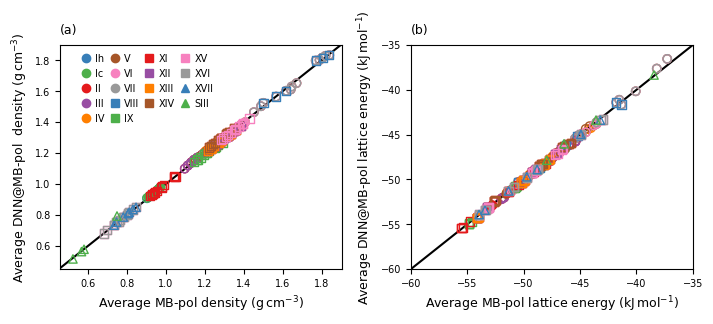

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(7.2,3))
ax1.axline((1, 1), slope=1,color='k',zorder=-10)
ax2.axline((1, 1), slope=1,color='k',zorder=-10)

common_sims=sorted(list(set(mbpol.keys()).intersection(set(deepmd.keys()))))
#ices=(list(set([sim.split('/')[0] for sim in common_sims])))

ices=['Ice_Ih','Ice_Ic','Ice_II','Ice_III','Ice_IV', 'Ice_V', 'Ice_VI',  'Ice_VII','Ice_VIII','Ice_IX','Ice_XI','Ice_XII','Ice_XIII','Ice_XIV','Ice_XV','Ice_XVI', 'Ice_XVII',       'Ice_SIII' ]
for ice in ices:
    for sim in common_sims:
        if ice not in sim:
            continue
        #ice=sim.split('/')[0]
        color=colors[ices.index(ice)]
        marker=markers[ices.index(ice)]
        if mbpol[sim]['Dens']<0.5:
            continue

        if deepmd[sim]['Dens']<0.5:
            continue
        ax1.scatter(mbpol[sim]['Dens'],deepmd[sim]['Dens'],color=color,marker=marker,facecolor="none",label=ice,zorder=-1)
        ax2.scatter(mbpol[sim]['Energy']*mev_to_kj,deepmd[sim]['Energy']*mev_to_kj,color=color,marker=marker,facecolor="none",label=ice,zorder=-1)

    
ax1.set_xlabel(r'Average MB-pol density (g$\,$cm$^{-3}$)')
ax1.set_ylabel(r'Average DNN@MB-pol  density (g$\,$cm$^{-3}$)')

#print(scatter.legend_elements())
handles=[mlines.Line2D([], [],
                          color=colors[ices.index(ice)], marker=markers[ices.index(ice)],
                         label=ice.replace('Ice_',''),linestyle='') for ice in ices]
ax1.legend(handles=handles,ncol=4,loc='upper center',prop={'size': 7},handletextpad=0.0,labelspacing=0.5,columnspacing=0.0,bbox_to_anchor=(0.3,1.0),frameon=False)#,bbox_to_anchor=(0.4,1.4))
#legend_without_duplicate_labels(plt.gca())
plt.tight_layout()
ax2.set_xlim(-60,-35.0)
ax2.set_ylim(-60,-35.0)
ax2.set_xlabel(r'Average MB-pol lattice energy (kJ$\,$mol$^{-1}$)')
ax2.set_ylabel(r'Average DNN@MB-pol lattice energy (kJ$\,$mol$^{-1}$)')
plt.tight_layout()

ax1.annotate('(a)',xy=(0,1.05),xycoords='axes fraction')
ax2.annotate('(b)',xy=(0,1.05),xycoords='axes fraction')


!rm -rf figs
!mkdir figs
plt.savefig('figs/DensityEnergyAvg.png',dpi=300,bbox_inches='tight')
plt.savefig('figs/DensityEnergyAvg.pdf',bbox_inches='tight')